<a href="https://colab.research.google.com/github/ffelicioni/conv3d_video/blob/main/clasificar_hands.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning - Clasificación de lenguaje de señas

## Módulos

In [2]:
import os as os
import pandas as pd
import glob
from pathlib import Path

from IPython.display import clear_output
import sys

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math as math

from google.colab.patches import cv2_imshow

import tensorflow as tf
from tensorflow import keras

import cv2

from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
from skimage import io

import random as random

import shutil

## Funciones

In [3]:
! mkdir /content/src
sys.path.append('./src')
% cd /content/src
archivos=['__init__.py','armado_dataset.py','clasificacion.py','visualizar_filtros.py','carga_datos.py','separar_train_test.py']
for archivo in archivos:
    !wget "https://raw.githubusercontent.com/ffelicioni/conv3d_video/main/src/{archivo}"
% cd /content

clear_output()

In [4]:
from armado_dataset import video_capturing_function, data_load_function_frames, resampling_rand, data_load_frames_save_tf, load_data_from_tf, df_videos_names
from separar_train_test import df_train_reordenar
from clasificacion import prob2labels, accuracy, confusion
from visualizar_filtros import plot_conv_weight, layer_by_name

Clase sequence para carga de datos

In [5]:
class CustomSequence(keras.utils.Sequence):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.n=3948 
    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, batch_index):
        idx_start = batch_index*self.batch_size
        idx_end = idx_start+self.batch_size
        
        X=load_data_from_tf(df_train_batch[idx_start:idx_end],"train_data")
        a=np.array(df_train_batch[idx_start:idx_end].ID)
        y = tf.keras.utils.to_categorical(a-1, num_classes =64)
        
        nf,w,h=X[0].shape
        X.reshape(self.batch_size,nf,w,h,1)
        return X, y

## Chequeo GPU

In [6]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [7]:
!/opt/bin/nvidia-smi

Tue Jul 12 18:17:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W /  70W |    284MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
import gc
gc.collect()

280

## Datasets

In [9]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [10]:
!unzip drive/MyDrive/lsa64_preprocessed.zip -d dataset
clear_output()

Armo dataset con nombres de los videos disponibles

In [11]:
df=df_videos_names('/content/dataset/lsa64_hand_videos/*.avi')
print('cantidad de videos:',len(sorted(glob.glob('/content/dataset/lsa64_hand_videos/*.avi'))))
print('cantidad de videos de la mano derecha:',len(df[df.mano=='right']))
print('cantidad de videos de la mano izquierda:',len(df[df.mano=='left']))
print('cantidad de personas:', len(df.persona.unique()))
print('cantidad de repeticiones:', len(df.repeticion.unique()))

cantidad de videos: 4299
cantidad de videos de la mano derecha: 3200
cantidad de videos de la mano izquierda: 1099
cantidad de personas: 10
cantidad de repeticiones: 5


In [12]:
clases=pd.read_csv('https://raw.githubusercontent.com/ffelicioni/conv3d_video/main/data/clase_LSA64.csv')
print('cantidad de clases:', len(clases.Name.unique()),'nombres: ',clases.Name.unique())

cantidad de clases: 63 nombres:  ['Opaque' 'Red' 'Green' 'Yellow' 'Bright' 'Light-blue' 'Colors' 'Women'
 'Enemy' 'Son' 'Man' 'Away' 'Drawer' 'Born' 'Learn' 'Call' 'Skimmer'
 'Bitter' 'Sweet milk' 'Milk' 'Water' 'Food' 'Argentina' 'Uruguay'
 'Country' 'Last name' 'Where' 'Mock' 'Birthday' 'Breakfast' 'Photo'
 'Hungry' 'Map' 'Coin' 'Music' 'Ship' 'None' 'Name' 'Patience' 'Perfume'
 'Deaf' 'Trap' 'Rice' 'Barbecue' 'Candy' 'Chewing-gum' 'Spaghetti'
 'Yogurt' 'Accept' 'Thanks' 'Shut down' 'Appear' 'To land' 'Catch' 'Help'
 'Dance' 'Bathe' 'Buy' 'Copy' 'Run' 'Realize' 'Give' 'Find']


hay 63 clases distintas porque la clase "Red" se repite. 

In [13]:
df['id_name']=pd.merge(df,clases,on='ID',how='left').Name
df

,file_path,ID,persona,repeticion,mano,id_name
0,/content/dataset/lsa64_hand_videos/001_001_001...,1,001,001,right,Opaque
1,/content/dataset/lsa64_hand_videos/001_001_002...,1,001,002,right,Opaque
2,/content/dataset/lsa64_hand_videos/001_001_003...,1,001,003,right,Opaque
3,/content/dataset/lsa64_hand_videos/001_001_004...,1,001,004,right,Opaque
4,/content/dataset/lsa64_hand_videos/001_001_005...,1,001,005,right,Opaque
...,...,...,...,...,...,...
4294,/content/dataset/lsa64_hand_videos/064_010_001...,64,010,001,right,Find
4295,/content/dataset/lsa64_hand_videos/064_010_002...,64,010,002,right,Find
4296,/content/dataset/lsa64_hand_videos/064_010_003...,64,010,003,right,Find
4297,/content/dataset/lsa64_hand_videos/064_010_004...,64,010,004,right,Find


Señas con cada mano

In [14]:
df[df.mano=='right']

,file_path,ID,persona,repeticion,mano,id_name
0,/content/dataset/lsa64_hand_videos/001_001_001...,1,001,001,right,Opaque
1,/content/dataset/lsa64_hand_videos/001_001_002...,1,001,002,right,Opaque
2,/content/dataset/lsa64_hand_videos/001_001_003...,1,001,003,right,Opaque
3,/content/dataset/lsa64_hand_videos/001_001_004...,1,001,004,right,Opaque
4,/content/dataset/lsa64_hand_videos/001_001_005...,1,001,005,right,Opaque
...,...,...,...,...,...,...
4294,/content/dataset/lsa64_hand_videos/064_010_001...,64,010,001,right,Find
4295,/content/dataset/lsa64_hand_videos/064_010_002...,64,010,002,right,Find
4296,/content/dataset/lsa64_hand_videos/064_010_003...,64,010,003,right,Find
4297,/content/dataset/lsa64_hand_videos/064_010_004...,64,010,004,right,Find


In [15]:
df[df.mano=='left'].ID.value_counts()

29    50
31    50
61    50
60    50
58    50
57    50
56    50
55    50
53    50
51    50
50    50
49    50
48    50
45    50
44    50
43    50
36    50
35    50
34    50
32    50
63    50
54    49
Name: ID, dtype: int64

In [16]:
df_right=df[df.mano=='right']

In [17]:
_, X_test_index, _, _ = train_test_split(df_right.index, df_right.ID, stratify=df_right.ID, test_size=260,random_state=0)

df_test=df_right.loc[sorted(X_test_index)]

In [18]:
df_uno=pd.merge(df_test,df,on=['ID','persona','repeticion'],how='left')
df_uno=df_uno[['file_path_y','ID','persona','repeticion','mano_y','id_name_y']]
df_uno.rename(columns={'file_path_y':'file_path','mano_y':'mano','id_name_y':'id_name'},inplace=True)
df_uno[df_uno.mano=='left']
df_uno

,file_path,ID,persona,repeticion,mano,id_name
0,/content/dataset/lsa64_hand_videos/001_001_002...,1,001,002,right,Opaque
1,/content/dataset/lsa64_hand_videos/001_001_005...,1,001,005,right,Opaque
2,/content/dataset/lsa64_hand_videos/001_007_002...,1,007,002,right,Opaque
3,/content/dataset/lsa64_hand_videos/001_009_002...,1,009,002,right,Opaque
4,/content/dataset/lsa64_hand_videos/001_009_003...,1,009,003,right,Opaque
...,...,...,...,...,...,...
346,/content/dataset/lsa64_hand_videos/063_010_003...,63,010,003,right,Give
347,/content/dataset/lsa64_hand_videos/064_001_005...,64,001,005,right,Find
348,/content/dataset/lsa64_hand_videos/064_006_005...,64,006,005,right,Find
349,/content/dataset/lsa64_hand_videos/064_009_003...,64,009,003,right,Find


In [19]:
df_test=df_uno.copy()

In [20]:
df_train=df[~df.file_path.isin(df_test.file_path)]

In [21]:
#df_uno[df_uno.mano_y=='left']['file_path_y'][113]

In [22]:
#df_uno['file_path_y'][0]

In [23]:
4299-(91+260)


3948

In [24]:
3948/4

987.0

Lotes de 4

In [25]:
batch=987
batch_size=4
cant_train=batch*batch_size 
n_test=len(df)-cant_train
print('entrenamiento:',cant_train, 'testing:', n_test,'-', (len(df)-cant_train)/cant_train,'%')
print('cantidad batch:',batch,'batch_size:', cant_train / batch)

entrenamiento: 3948 testing: 351 - 0.08890577507598785 %
cantidad batch: 987 batch_size: 4.0


In [26]:
#X_train_index, X_test_index, y_train, y_test = train_test_split(df.index, df.ID, stratify=df.ID, test_size=n_test,random_state=0)

#df_train=df.loc[sorted(X_train_index)]

#df_test=df.loc[sorted(X_test_index)]

#df_train_batch=df_train_reordenar(df_train,cant_train,batch)

Separo en conjuntos de acuerdo. 

In [27]:
df_train_batch=df_train_reordenar(df_train,cant_train,batch)

In [28]:
df_train_batch[df_train_batch.mano=='left'].loc[1638]

file_path     /content/dataset/lsa64_hand_videos/031_009_005...
ID                                                           31
persona                                                     009
repeticion                                                  005
mano                                                       left
id_name                                               Breakfast
Name: 1638, dtype: object

In [29]:
df_train_batch[((df_train_batch.ID==31)&(df_train_batch.persona=='009')&(df_train_batch.repeticion=='005'))]

,file_path,ID,persona,repeticion,mano,id_name
1638,/content/dataset/lsa64_hand_videos/031_009_005...,31,009,005,left,Breakfast
1639,/content/dataset/lsa64_hand_videos/031_009_005...,31,009,005,right,Breakfast


In [30]:
%ls

dataset/  drive/  sample_data/  src/


# Data training - test

Con la separación realizada se arman dos carpetas: train_data y test_data. Cada video fue convertido a un conjunto de imágenes de 1 solo canal, dentro de cada archivo.

Referencia 
https://medium.com/video-classification-using-keras-and-tensorflow/action-recognition-and-video-classification-using-keras-and-tensorflow-56badcbe5f77

In [31]:
video_capturing_function(df_train,'train_data')

video_capturing_function(df_test,'test_data')

All frames written in the: train_data Folder
All frames written in the: test_data Folder


In [32]:
gc.collect()

50

### Ejemplo 
Imágenes de uno de los videos

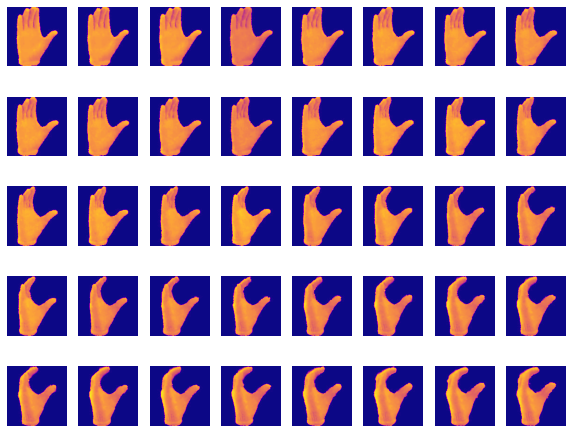

In [33]:
rows,cols = 5,8
f,ax=plt.subplots(rows,cols,figsize=(rows*2,cols*1))
for i in range(rows):
  for j in range(cols):
    x = (io.imread("/content/train_data/001_001_001_right/frame"+str(i*5+j)+".jpg")/255.0).astype('float32')
    ax[i,j].imshow(x,cmap='plasma')#,vmin=0,vmax=1) #plasma
    ax[i,j].axis('off')

Dimensiones de la imagen:


<Figure size 432x288 with 0 Axes>

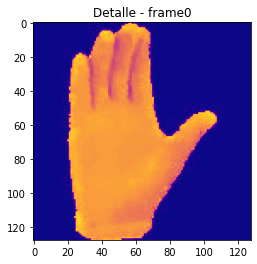

<Figure size 432x288 with 0 Axes>

In [34]:
imagen0=(io.imread("/content/train_data/001_001_001_right/frame0.jpg")/255.0).astype('float32')
plt.imshow(imagen0)

print("Dimensiones de la imagen:")
plt.imshow(imagen0,cmap='plasma')#vmin=0,vmax=1)
plt.title("Detalle - frame0")
plt.figure()

### Obtención de tensores 

**Funcion "data_load_frames_save_tf"**

Proceso los videos y selecciono 32 frames del total de videos de forma aleatoria, en caso que los videos tengan menos frames repito el último hasta completar los 32.

Los frames de cada video (imágenes) se pasan a tensores de numpy para que cuando se desee cargar lotes no se tenga que procesar imagenes sino leer archivos numpy previamente salvados. Los tensores son grabados en float32 para reducir el tamaño de archivos.

La función borra además las imágenes para no sobrecargar el disco de la máqunia del colab.

Los archivos de los tensores de numpy se guardan en **train_data** y **test_data**

In [35]:
data_load_frames_save_tf(df_test,'test_data',32)
data_load_frames_save_tf(df_train,'train_data',32)

In [36]:
gc.collect()

142

# Modelo Convolucional 3D 


In [37]:
test_dataset_new=load_data_from_tf(df_test,"test_data")

In [38]:
test_dataset_new.shape

(351, 32, 128, 128)

In [39]:
a=np.array(df_test.ID)
y_test = tf.keras.utils.to_categorical(a-1, num_classes =np.max(df_test.ID))

model_output_size=len(df_test.ID.unique())
model_output_size

64

Conv2D(stride_temporal=2)->
Conv2D(stride_temporal=2,stride_espacial=2) -> Conv2D(stride_temporal=2) -> Conv2D(stride_temporal=2,stride_espacial=2)

In [40]:
nf=32
w=128 
h=128

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

def create_model():

    model = Sequential()

    model.add(Conv3D(filters = 32, kernel_size = (3, 3,3), strides=(2,1,1), padding='same', activation = 'relu', input_shape = (nf,w, h, 1)))
    model.add(Conv3D(filters = 32, kernel_size = (3, 3,3),strides=(2,2,2), padding='same', activation = 'relu'))
    model.add(Conv3D(filters = 32, kernel_size = (3, 3,3),strides=(2,1,1), padding='same', activation = 'relu'))
    model.add(Conv3D(filters = 64, kernel_size = (3, 3,3),strides=(2,2,2), padding='same', activation = 'relu')) 
    
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size = (2, 2,2)))
    model.add(GlobalAveragePooling3D())

    model.add(Dense(model_output_size, activation = 'softmax'))

    model.summary()

    return model


model = create_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 128, 128, 32)  896       
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 64, 64, 32)     27680     
                                                                 
 conv3d_2 (Conv3D)           (None, 4, 64, 64, 32)     27680     
                                                                 
 conv3d_3 (Conv3D)           (None, 2, 32, 32, 64)     55360     
                                                                 
 batch_normalization (BatchN  (None, 2, 32, 32, 64)    256       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 1, 16, 16, 64)    0         
 )                                                      

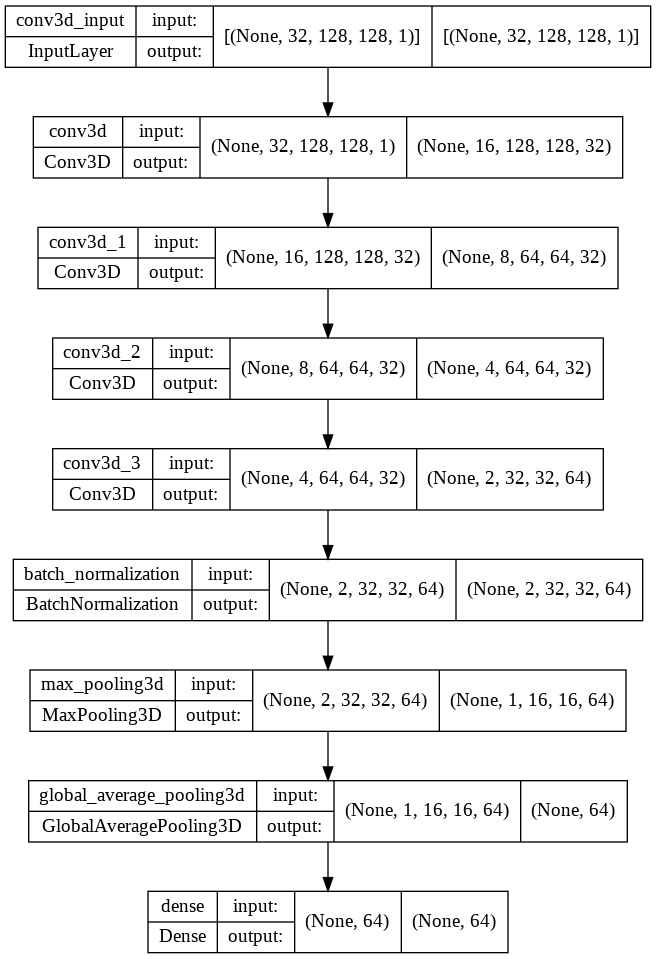

In [41]:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

### Entrenamiento con Custom Sequence 

La función CustomSequence carga cada lote con 128 tensores numpy guardados en la carpeta train_data (nombre de archivo.npy) usando la función 
**load_data_from_tf**. 

In [42]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# usando generador custom
model_training_history = model.fit(CustomSequence(4), epochs=40 , validation_data=(test_dataset_new,y_test), callbacks = [early_stopping_callback]) #, shuffle = True

Epoch 1/40
987/987 [==============================] - 71s 60ms/step - loss: 3.8097 - accuracy: 0.0565 - val_loss: 3.5532 - val_accuracy: 0.0912
Epoch 2/40
987/987 [==============================] - 59s 60ms/step - loss: 3.3840 - accuracy: 0.1264 - val_loss: 3.1853 - val_accuracy: 0.1624
Epoch 3/40
987/987 [==============================] - 58s 59ms/step - loss: 3.0026 - accuracy: 0.2171 - val_loss: 2.7557 - val_accuracy: 0.2678
Epoch 4/40
987/987 [==============================] - 59s 59ms/step - loss: 2.6284 - accuracy: 0.3002 - val_loss: 2.3807 - val_accuracy: 0.3390
Epoch 5/40
987/987 [==============================] - 57s 58ms/step - loss: 2.3084 - accuracy: 0.3837 - val_loss: 2.1212 - val_accuracy: 0.4131
Epoch 6/40
987/987 [==============================] - 58s 58ms/step - loss: 2.0228 - accuracy: 0.4397 - val_loss: 2.0017 - val_accuracy: 0.4587
Epoch 7/40
987/987 [==============================] - 114s 116ms/step - loss: 1.7477 - accuracy: 0.5284 - val_loss: 1.7360 - val_accurac

In [59]:
print("Saving trained model..")
model.save('conv3d_lsa64.h5')
print("Done.")

Saving trained model..
Done.


In [60]:
y_predict=model.predict(test_dataset_new)
y_pred=prob2labels(y_predict)
accuracy(np.array(df_test.ID)-1,y_pred)

0.792022792022792

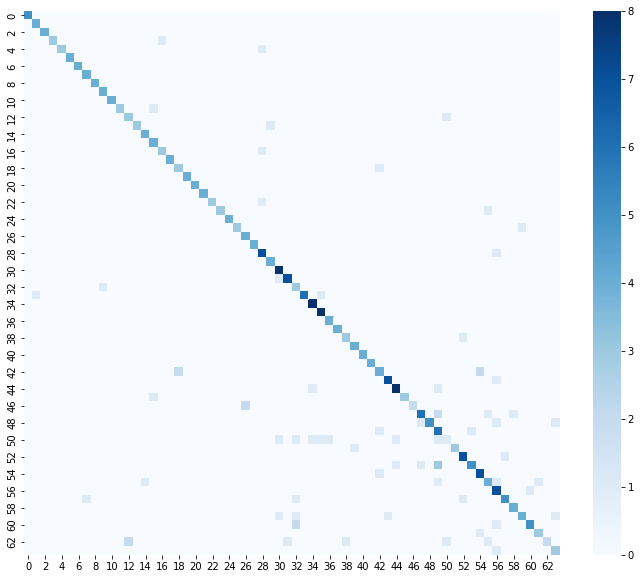

In [61]:
confusion_calculada=confusion(np.array(df_test.ID)-1,y_pred).astype(int)
names=df.id_name.unique()

plt.figure(figsize=(12,10))
import seaborn as sns
sns.heatmap(confusion_calculada, cmap="Blues") #,annot=True

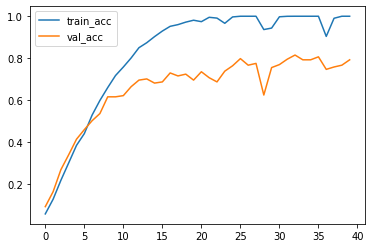

In [62]:
plt.plot(model_training_history.history['accuracy'])
plt.plot(model_training_history.history['val_accuracy'])
plt.legend(['train_acc','val_acc'])

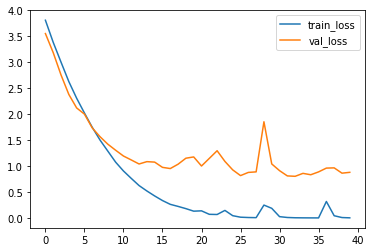

In [63]:
plt.plot(model_training_history.history['loss'])
plt.plot(model_training_history.history['val_loss'])
plt.legend(['train_loss','val_loss'])

Visualización de filtros del modelo

In [64]:
for layer in model.layers:
    if 'conv'  in layer.name.lower():
      filters, biases = layer.get_weights()
      print(layer.name,filters.shape)
    else:
      weights = layer.get_weights()
      if len(weights)>0:
        message = ",".join([str(w.shape) for w in weights])
      else:
        message="none"
      print(f"{layer.name} weights: {message}")


conv3d (3, 3, 3, 1, 32)
conv3d_1 (3, 3, 3, 32, 32)
conv3d_2 (3, 3, 3, 32, 32)
conv3d_3 (3, 3, 3, 32, 64)
batch_normalization weights: (64,),(64,),(64,),(64,)
max_pooling3d weights: none
global_average_pooling3d weights: none
dense weights: (64, 64),(64,)


filters - primera capa - 0 a 8


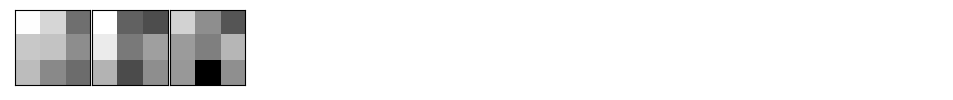

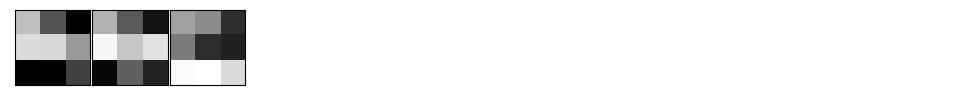

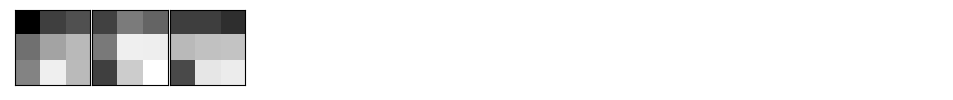

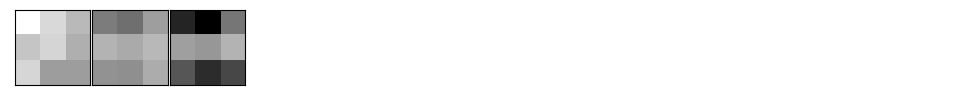

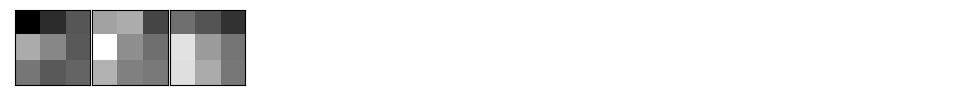

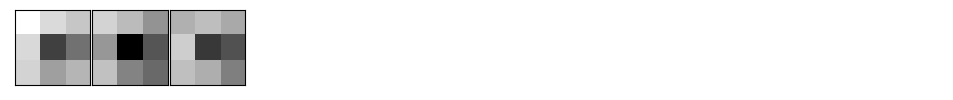

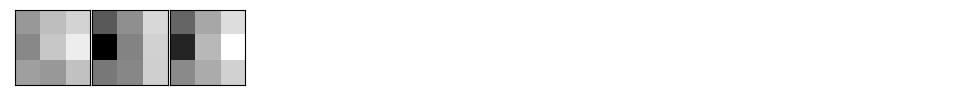

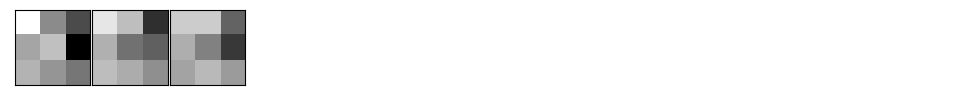

In [65]:
#Elegir capa convolucional y nro de filtro
layer_name="conv3d"
filter_index=0

layer = layer_by_name(model,layer_name)
filters, biases = layer.get_weights()

#filters.shape[4]//4

print('filters - primera capa - 0 a 8')
# 8 primeros filtros de la primera capa convolucional
for i in range(0,8): 
  plot_conv_weight(layer.name,filters[:,:,:,0,i])

filters - primera capa - 8 a 16


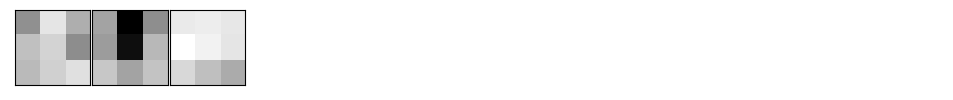

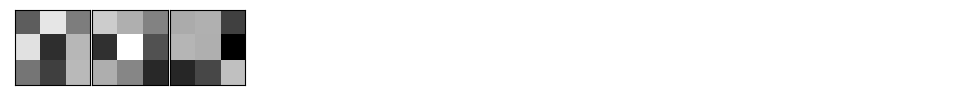

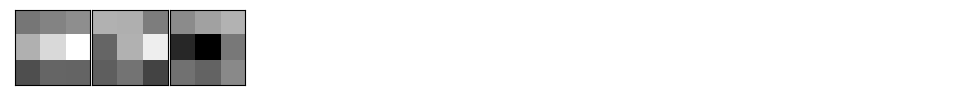

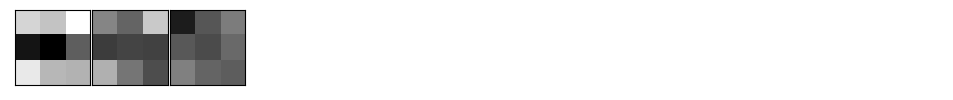

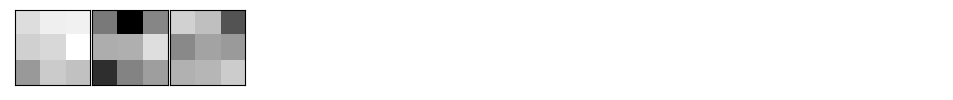

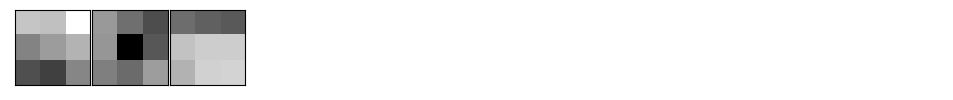

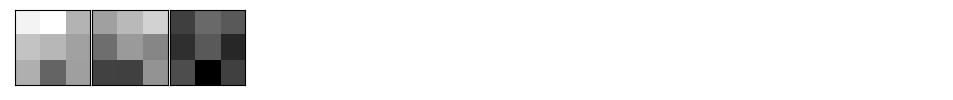

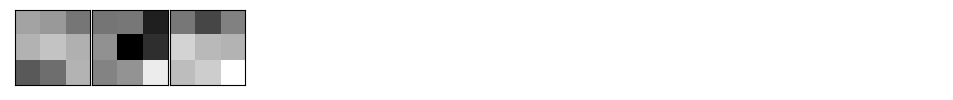

In [66]:
print('filters - primera capa - 8 a 16')
# 8 segundos filtros de la primera capa convolucional
for i in range(8,16): 
  plot_conv_weight(layer.name,filters[:,:,:,0,i])

In [51]:
filters.shape

(3, 3, 3, 1, 32)

In [67]:
from matplotlib import pyplot


In [68]:
ejemplo=pd.DataFrame(df_train_batch.loc[0]).T
X=load_data_from_tf(ejemplo,"train_data")
X.shape

(1, 32, 128, 128)

In [69]:
df_train_batch.loc[0]

file_path     /content/dataset/lsa64_hand_videos/001_001_001...
ID                                                            1
persona                                                     001
repeticion                                                  001
mano                                                      right
id_name                                                  Opaque
Name: 0, dtype: object

In [70]:
visualization_model = tf.keras.models.Model(inputs=model.inputs, outputs=model.layers[0].output)

In [71]:
feature_maps = visualization_model.predict(X)

In [72]:
feature_maps.shape

(1, 16, 128, 128, 32)

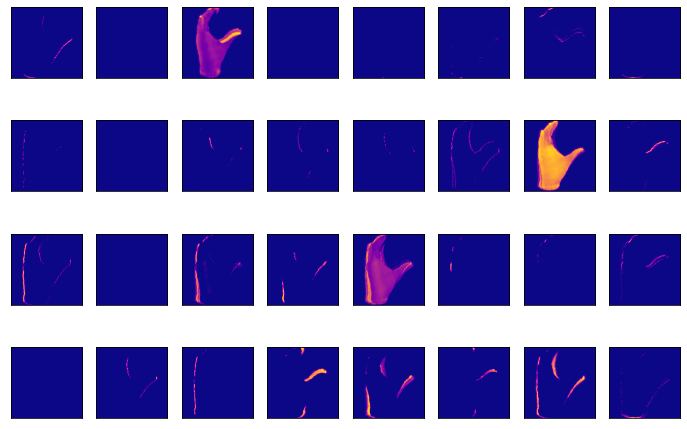

In [75]:
rows,cols = 4,8
f,ax=plt.subplots(rows,cols,figsize=(rows*3,cols*1))

# plot all 64 maps in an 8x8 squares
ix = 1
for _ in range(cols):
	for _ in range(rows):
		# specify subplot and turn of axis
		ax = pyplot.subplot(rows,cols, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, 3, :,:, ix-1], cmap='plasma')
		ix += 1
# show the figure
pyplot.show()